In [1]:
import os
os.chdir("/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1")
os.getcwd()

'/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1'

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from helpers.model_helpers import make_and_restore_model
from helpers.trainer_helpers import batch_uncertain, eval_model
from helpers.vis_helpers import show_image_row_heatmap
from robustness.tools.vis_tools import show_image_row
from cox.utils import Parameters
import helpers.defaults_helpers as defaults
from helpers import data_helpers
from helpers.dataset_helpers import CIFAR, Places10, ImageNet, CIFAR100
from helpers import vis_helpers
from helpers import feature_helpers
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import os
import logging
import torch.nn.functional as F

os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/helpers/trainer_helpers.py:28: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, imgs_tensor, labels):
        self.imgs_tensor = imgs_tensor
        self.labels = labels
        # self.classes = 1000

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.imgs_tensor[idx]
        label = self.labels[idx]
        return image, label

In [4]:
DATASET_NAME = "imagenet"#'cifar-100'
if DATASET_NAME == 'imagenet':
    DATASET_PATH = '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/DebuggableDeepNetworks/dataset/imagenet'  # Path to dataset
    DATASET_TYPE = 'vision'
    MODEL_PATH = "/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/pretrain_model_imagenet/sparse_resnet50_from_start/checkpoint.pt.best"  # None # Path to deep network
    ARCH = 'resnet50'
    BATCH_SIZE = 256
elif DATASET_NAME == 'cifar-10':
    DATASET_PATH = '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/DebuggableDeepNetworks/dataset/cifar10'
    DATASET_TYPE = 'vision'
    MODEL_PATH ="../pretrain_model_cifar10/sparse_resnet18wide/checkpoint.pt.best"
    ARCH = "resnet18wide"
    BATCH_SIZE = 128
elif DATASET_NAME == 'cifar-100':
    DATASET_PATH = '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/DebuggableDeepNetworks/dataset/cifar100'
    DATASET_TYPE = 'vision'
    MODEL_PATH = "../pretrain_model_cifar100/best_kl_repar_kw/checkpoint.pt.best"
    ARCH = "resnet18wide"
    BATCH_SIZE = 128


train_kwargs = {
    'out_dir': "train_out",
    'adv_eval': 0,
    'adv_train': 0,
    'constraint': '2',
    'eps': 0.5,
    'attack_lr': 1.5,
    'attack_steps': 20,
    'epochs': 20,
    # 'lr': 0.0001,
    'log_iters': 1
}
args = Parameters(train_kwargs)
if args.dataset in ['cifar', 'cifar10', 'cifar-100']:
    args = defaults.check_and_fill_args(args, defaults.TRAINING_ARGS, CIFAR)
    args = defaults.check_and_fill_args(args,
                                        defaults.PGD_ARGS, CIFAR)
elif args.dataset in ['imagenet', 'places10']:
    args = defaults.check_and_fill_args(args,
                                        defaults.TRAINING_ARGS, ImageNet)
    args = defaults.check_and_fill_args(args,
                                        defaults.PGD_ARGS, ImageNet)


In [5]:
## sorted lime exp
testresult_path = f"/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/vis/vis_files/testresult_pred_{DATASET_NAME}.pth"
# test_loader
dataset, train_loader, test_loader = data_helpers.load_dataset(DATASET_NAME,
                                                               os.path.expandvars(DATASET_PATH),
                                                               DATASET_TYPE,
                                                               BATCH_SIZE,
                                                               num_workers=10,
                                                               shuffle=False,
                                                               model_path=MODEL_PATH)

# load model
# class_dict = data_helpers.get_label_mapping(DATASET_NAME)
model, _ = make_and_restore_model(arch=ARCH, dataset=dataset, resume_path=MODEL_PATH, parallel=True)
model.eval()
model.cuda()

if not os.path.exists(testresult_path):
    with torch.no_grad():
        _, prec, pavpu, testresult, out_logits = eval_model(args, model, test_loader, original_arch=False,
                                                            store=None)
        torch.save({'testresult': testresult, 'out_logits': out_logits}, testresult_path)
else:
    testresult = torch.load(testresult_path)['testresult']
    out_logits = torch.load(testresult_path)['out_logits']
    print(f"=> loaded from {testresult_path}")
sorted_indices = testresult.squeeze(dim=-1).sort().indices # sort according to uncertainty
pred_labels = torch.argmax(out_logits, dim=-1)

test_images, test_labels = [], []
for _, (im, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    test_images.append(im)
    test_labels.append(label)
test_images, test_labels = torch.cat(test_images), torch.cat(test_labels)


==> Preparing dataset imagenet..
=> loading checkpoint '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/pretrain_model_imagenet/sparse_resnet50_from_start/checkpoint.pt.best'
=> loaded checkpoint '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/pretrain_model_imagenet/sparse_resnet50_from_start/checkpoint.pt.best' (epoch 18)
=> loaded from /mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/vis/vis_files/testresult_pred_imagenet.pth


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [01:08<00:00,  2.87it/s]


In [117]:
Top_Uncertainty = 10
Thresh = 1e-3
Nfeatures = 1

iteration = 3
# for i in range(iteration):
    
#     if i == 0:
#         chosen_indices = sorted_indices[-Top_Uncertainty * (i + 1): ]
#     else:
#         chosen_indices = sorted_indices[-Top_Uncertainty * (i + 1): -Top_Uncertainty * i]
used_indices = sorted_indices[: Top_Uncertainty] # chosen_indices

class_dict = data_helpers.get_label_mapping(DATASET_NAME)
class_name = [class_dict[i] for i in test_labels[used_indices].tolist()] #set(class_dict[test_labels[used_indices]])
pred_name = [class_dict[i] for i in pred_labels[used_indices].tolist()]
print(f'class name {class_name}')
print(f'predicted name {pred_name}')


# get_lime_exp_given_image
        
FEATURE_PATH = '/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/tmp/joint_features/imagenet_from_start/features'#f"/mnt/wwn-0x5000c500e040f04e-part1/hxy/2024-XAI/Debuggable_v1/tmp/joint_features/{DATASET_NAME}/"
features, feature_mean, feature_std = feature_helpers.load_features_mode(FEATURE_PATH, mode='test',
                                                                        batch_size=BATCH_SIZE,
                                                                         num_workers=8)


rng = np.random.RandomState(2)

pcs = test_labels[used_indices].tolist()#rng.choice(1000, 1)[0]
print(f"chosen neuron {pcs}")
weight = F.relu(model.module.model.fc.weight.data.detach().cpu())
used_weights = weight[pcs]
feature_indices, signs, weights, Nfs = [], [], [], []
for weight_type in ['sparse', 'dense']:
    used_idx = []
    for used_weight in used_weights:
        weight_class = vis_helpers.normalize_weight(used_weight)

        rel_idx = np.where(weight_class > Thresh)[0]

        if weight_type == 'sparse':
            Nf = 1 #len(rel_idx)

        largest_features = rel_idx[np.argsort(-weight_class[rel_idx])]
        feature_idx = rng.choice(largest_features[: Nf], Nfeatures, replace=True)
        feature_idx = feature_idx[np.argsort(-weight_class[feature_idx])]
        used_idx.append(int(feature_idx))
        print(f'used_idx {used_idx}')
    for x, y in zip([feature_indices, signs, weights, Nfs],
                    [used_idx, np.sign(weight_class[used_idx]),
                     weight_class[used_idx], len(rel_idx)]):
        x.append(y)
# feature_indices = feature_indices * int(len(used_indices) / 2)
# signs = signs * int(len(used_indices) / 2)
# print(f'feature_indices {feature_indices}')
# print(f'signs {signs}')
feature_indices, signs = np.concatenate(feature_indices), np.concatenate(signs)

lime_exp, bg_mask = vis_helpers.get_lime_explanation(model,
                                                     feature_indices,
                                                     signs,
                                                     test_images[used_indices].double(),
                                                     feature_mean, feature_std,
                                                     NLime=10, # 10
                                                     background_color=0.6)




class name ['quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'magpie', 'pool table, billiard table, snooker table', 'cowboy boot', 'quill, quill pen', 'neck brace']
predicted name ['quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'quill, quill pen', 'magpie', 'pool table, billiard table, snooker table', 'cowboy boot', 'quill, quill pen', 'neck brace']
==> loaded 3 files of representations...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 100.18it/s]


chosen neuron [749, 749, 749, 749, 749, 18, 736, 514, 749, 678]
used_idx [660]
used_idx [660, 660]
used_idx [660, 660, 660]
used_idx [660, 660, 660, 660]
used_idx [660, 660, 660, 660, 660]
used_idx [660, 660, 660, 660, 660, 1847]
used_idx [660, 660, 660, 660, 660, 1847, 519]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662, 660]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662, 660, 703]
used_idx [660]
used_idx [660, 660]
used_idx [660, 660, 660]
used_idx [660, 660, 660, 660]
used_idx [660, 660, 660, 660, 660]
used_idx [660, 660, 660, 660, 660, 1847]
used_idx [660, 660, 660, 660, 660, 1847, 519]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662, 660]
used_idx [660, 660, 660, 660, 660, 1847, 519, 662, 660, 703]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

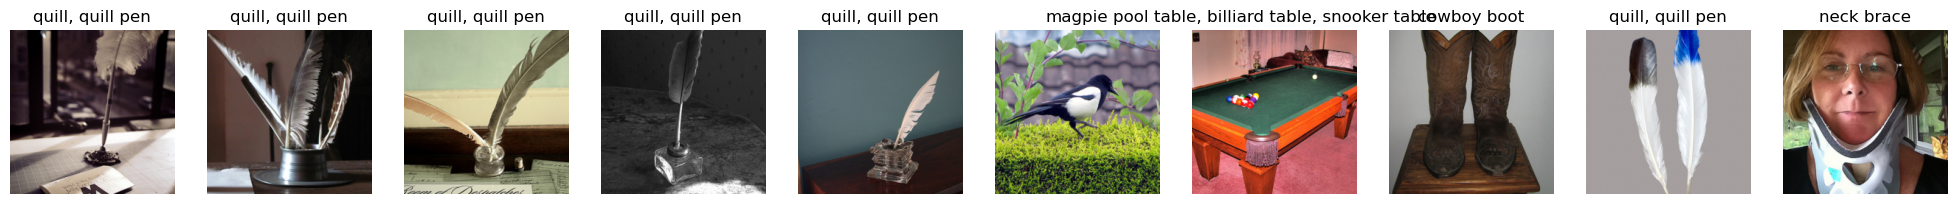

In [118]:
fig_origin = show_image_row([test_images[used_indices]],
               ['Image samples'],
               tlist=[[f"{item}" for item in np.array(class_name)], ["" for _ in range(Nfeatures)]])
plt.show()
vis_img = test_images[used_indices]
# fig_origin.savefig('vis/vis_result/low_uncertainty/quill_neckbrace.svg', transparent=True)

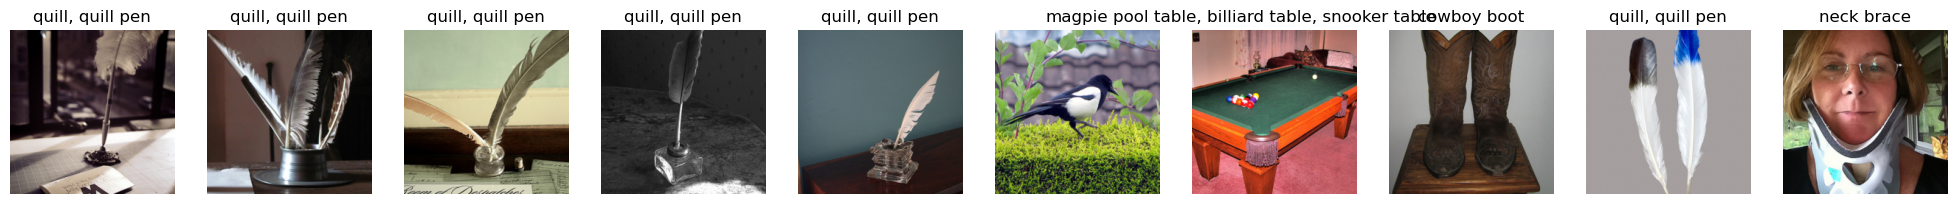

In [119]:
show_image_row([test_images[used_indices]],
               ['Image samples'],
               tlist=[[f"{item}" for item in class_name], ["" for _ in range(Nfeatures)]])
plt.show()
vis_img = test_images[used_indices]

In [120]:
bg_mask.shape
a = bg_mask[0]
a.shape
(a[0] != a[1]).sum()
(a[1] != a[2]).sum()
lime_exp.shape

torch.Size([10, 3, 224, 224])

In [121]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

from torchvision import transforms
from matplotlib.colors import ListedColormap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)
mask_blurred shape (224, 224, 3)


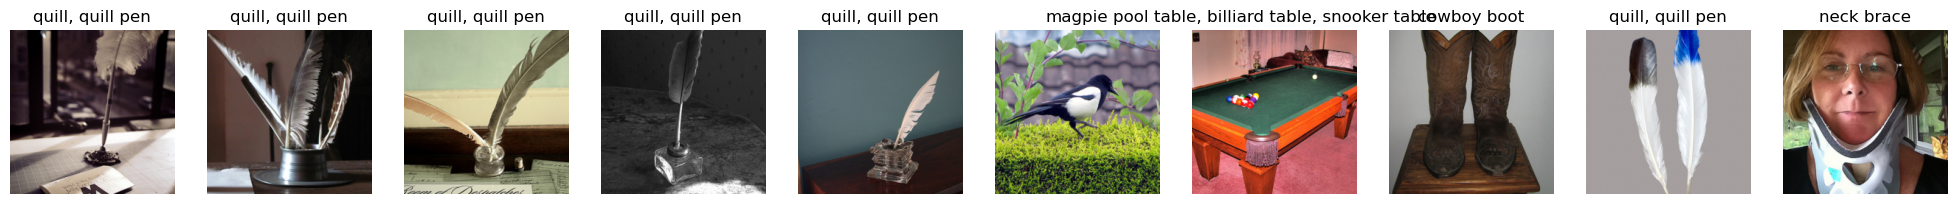

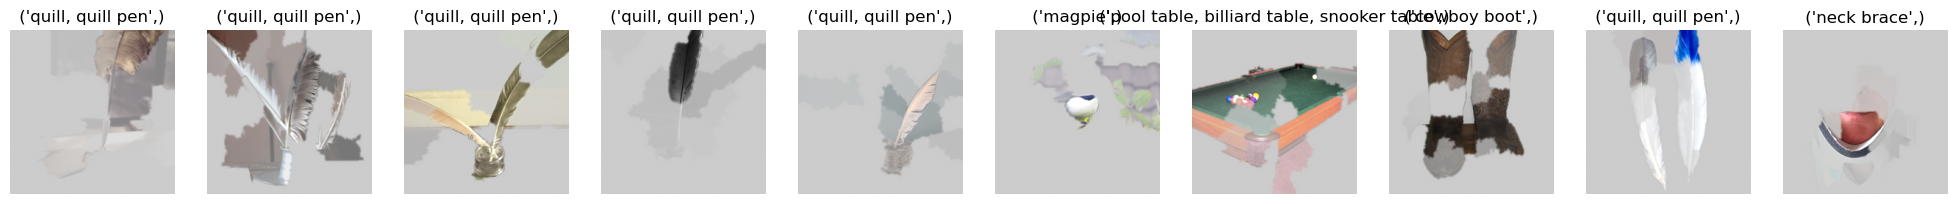

In [125]:
from skimage import measure
from scipy.ndimage import gaussian_filter
def apply_mask_with_gradient(image, mask):
    return image * mask * 1.1 + (1 - mask) * 0.8 # np.mean(image)

idx =   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

xlist = [vis_img[idx]]

heatmap_list = [bg_mask[idx]]

H, W = len(xlist), len(xlist[0])

tlist=[[f" {item[: 25]} " for item in zip(np.array(pred_name)[idx])], ["" for _ in range(Nfeatures)]]

alpha = 0.9

ylist=None 
fontsize=12
size=(2.5, 2.5)

show_image_row([test_images[used_indices[idx]]],
               ['Image samples'],
               tlist=[[f"{item}" for item in np.array(class_name)[idx]], ["" for _ in range(Nfeatures)]])

fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
for w in range(W):
    for h in range(H):
        ax = get_axis(axarr, H, W, h, w)
        x = xlist[h][w].permute(1, 2, 0) #im = ax.imshow(xlist[h][w].permute(1, 2, 0))
#         im = ax.imshow(x)
        heatmap = np.maximum(heatmap_list[h][w].permute(1, 2, 0), 0)
        heatmap = heatmap / torch.max(heatmap)

        mask_blurred = gaussian_filter(heatmap, sigma=1) 
        print(f'mask_blurred shape {mask_blurred.shape}')
        processed_img = apply_mask_with_gradient(x.detach().cpu().numpy(), mask_blurred)
#         heatmap_img = transforms.ToPILImage()(heatmap_img.permute(2, 0, 1))
        ax.imshow(processed_img)# (heatmap_img)
        
#         contours = measure.find_contours(heatmap[:, :, 0].numpy(), level=0.1)
#         for contour in contours:
#             ax.plot(contour[:, 1], contour[:, 0], linestyle='--', color='k', linewidth=1)  # \u7ed8\u5236\u865a\u7ebf\u8fb9\u754c

        
#         x = ((x - x * heatmap).permute(2, 0, 1))
#         ax.imshow(x)
        
#         colors = [(0, 0, 0, alpha) for alpha in np.linspace(1, 0, 100)]
#         cmap = ListedColormap(colors)
#         ax.imshow(heatmap, alpha=alpha)
        ax.axis("off")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        if ylist and w == 0: 
            ax.set_ylabel(ylist[h], fontsize=fontsize)
        if tlist:
            ax.set_title(tlist[h][w], fontsize=fontsize)
#         plt.colorbar(im, ax=ax)

In [77]:
fig.savefig('vis/vis_result/low_uncertainty/qillpen_mask.svg', transparent=True)